In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from torch import nn

In [ ]:
torch.manual_seed(123)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

In [ ]:
train_set = torchvision.datasets.FashionMNIST(root='./', download = True, train =True, transform = transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.10MB/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size, shuffle = True)

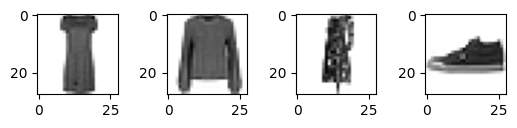

In [ ]:
real_samples, labels = next(iter(train_loader))

for i in range(4):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(real_samples[i].reshape(28,28), cmap = 'gray_r')

In [ ]:
class D(nn.Module):
  def __init__(self):
        super().__init__()
        self.model = nn.Sequential(

            # Первый свёрточный слой: 1 -> 64 канала
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Второй свёрточный слой: 64 -> 128 канала
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Третий свёрточный слой: 128 -> 256 канала
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Преобразование в вектор и классификация
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 1),
            nn.Sigmoid()

        )

  def forward(self, x):
      return self.model(x)

In [ ]:
class G(nn.Module):
  def __init__(self):
        super().__init__()
        self.model = nn.Sequential(

            # Преобразование входного шума в тензор 128 каналов 7x7
            nn.Linear(100, 128 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (128, 7, 7)),

            # Свёрточный транспонированный слой 1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Свёрточный транспонированный слой 2
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()

        )

  def forward(self, x):
      return self.model(x)

In [ ]:
num_epoch = 50
lr = 0.0002
loss_function = nn.BCELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = G().to(device)
discriminator = D().to(device)

optimizer_d = torch.optim.Adam(discriminator.parameters(),lr=lr)
optimizer_g = torch.optim.Adam(generator.parameters(),lr=lr)

In [ ]:
# Обучение
for epoch in range(num_epoch):
    for i, (real_samples, _) in enumerate(train_loader):

        # Обучение дискриминатора

        # Подготовка данных
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)
        real_labels = torch.ones((batch_size, 1)).to(device)
        generated_labels = torch.zeros((batch_size, 1)).to(device)

        # Реальные данные
        outputs = discriminator(real_samples)
        loss_real = loss_function(outputs, real_labels)

        # Сгенерированные данные
        noise_samples = torch.randn(batch_size, 100).to(device)
        generated_images = generator(noise_samples)
        outputs = discriminator(generated_images.detach())
        loss_generated = loss_function(outputs, generated_labels)

        # Итоговые потери дискриминатора
        loss_discriminator = loss_real + loss_generated
        optimizer_d.zero_grad()
        loss_discriminator.backward()
        optimizer_d.step()

        # Обучение генератора

        noise_samples = torch.randn(batch_size, 100).to(device)
        generated_images = generator(noise_samples)
        outputs = discriminator(generated_images)
        loss_generator = loss_function(outputs, real_labels)
        optimizer_g.zero_grad()
        loss_generator.backward()
        optimizer_g.step()

        # Вывод потерь
        if i % 469 == 0:
          print(f'{epoch} LOSS D: {loss_discriminator}')
          print(f'{epoch} LOSS G: {loss_generator}')

0 LOSS D: 0.054648257791996
0 LOSS G: 5.774075508117676
1 LOSS D: 0.0440070740878582
1 LOSS G: 5.606814384460449
2 LOSS D: 0.15139831602573395
2 LOSS G: 4.37944221496582
3 LOSS D: 0.16348090767860413
3 LOSS G: 7.333256721496582
4 LOSS D: 0.08347051590681076
4 LOSS G: 4.68574333190918
5 LOSS D: 0.071296326816082
5 LOSS G: 4.289815902709961
6 LOSS D: 0.10101322084665298
6 LOSS G: 3.814018487930298
7 LOSS D: 0.06382978707551956
7 LOSS G: 5.159824371337891
8 LOSS D: 0.21367838978767395
8 LOSS G: 6.697989463806152
9 LOSS D: 0.09132051467895508
9 LOSS G: 4.782288551330566
10 LOSS D: 0.05268175154924393
10 LOSS G: 4.958168029785156
11 LOSS D: 0.1294090747833252
11 LOSS G: 5.353189468383789
12 LOSS D: 0.08495541661977768
12 LOSS G: 5.078154563903809
13 LOSS D: 0.10139354318380356
13 LOSS G: 3.23687744140625
14 LOSS D: 0.16454437375068665
14 LOSS G: 5.883917331695557
15 LOSS D: 0.10904762893915176
15 LOSS G: 3.0470757484436035
16 LOSS D: 0.37284696102142334
16 LOSS G: 2.872133255004883
17 LOSS 

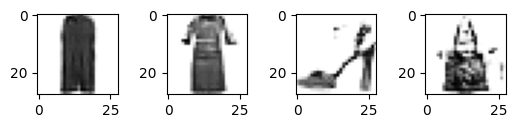

In [ ]:
noise_samples = torch.randn(batch_size,100).to(device)
generated_samples = generator(noise_samples)
generated_samples = generated_samples.detach().cpu()

for i in range(4):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(generated_samples[i].reshape(28,28), cmap = 'gray_r')

In [ ]:
class Сlassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(

            # Первый свёрточный слой: 1 -> 32 канала
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Второй свёрточный слой: 32 -> 64 канала
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Преобразование в вектор и классификация
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Загрузка реальных и сгенерированных данных для обучения классификатора
classifier = Сlassifier().to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epoch):
    for i, (real_samples, labels) in enumerate(train_loader):
        real_samples = real_samples.to(device)
        labels = labels.to(device)

        # Предсказания и вычисление ошибки
        outputs = classifier(real_samples)
        loss = criterion(outputs, labels)

        # Обновление параметров
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Вывод потерь
        if i % 469 == 0:
          print(f'{epoch} LOSS D: {loss}')

0 LOSS D: 2.3046340942382812
1 LOSS D: 0.5420120358467102
2 LOSS D: 0.46269017457962036
3 LOSS D: 0.3612482249736786
4 LOSS D: 0.340904176235199
5 LOSS D: 0.38242775201797485
6 LOSS D: 0.29457157850265503


In [ ]:
# Тестирование классификатора на сгенерированных изображениях

# Генерация тестовых данных
noise_samples = torch.randn(100, 100).to(device)  # 100 тестовых изображений
generated_samples = generator(noise_samples)
generated_samples = generated_samples.detach().cpu()

# Предсказания классификатора для сгенерированных изображений
classifier.eval()  # Перевод классификатора в режим оценки
with torch.no_grad():
    outputs = classifier(generated_samples.to(device))
    _, predicted = torch.max(outputs, 1)

# Вывод предсказаний
print("Предсказанные классы для сгенерированных изображений:")
predicted
